<a href="https://colab.research.google.com/github/geoaigroup/models-deployment/blob/main/scripts/process_large_tiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML4CV project work

Summary: Improving and explaining instance segmentation on a litter detection dataset

Members:
- Dell'Olio Domenico
- Delvecchio Giovanni Pio
- Disabato Raffaele

The project was developed in order to improve instance segmentation results on the [TACO Dataset](http://tacodataset.org/).

We decided to implement and test various architectures, among the highest scoring on COCO instance segmentation datasets, in order to compare their performances.
We also tested some explainability methods on these models to try and explain model predictions.

## This notebook contains:
- Wrapper of the MaskDINO model that merges the instance segmentation masks,
casting the instance segmentation task to a semantic segmentation task
- Calls to compute the eigen-cam for semantic segmentation, with the purpose of visualization of the most salient features for the segmentation of images of the validation set

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@5aeb252b194b93dc2879b4ac34bc51a31b5aee13'
%cd /content/

In [ ]:
!git clone https://github.com/DomMcOyle/TACO-expl.git
%cd /content/TACO-expl
!git checkout pre_main_merge
!git pull origin pre_main_merge
%cd /content/TACO-expl/MaskDINO
!pip install -r requirements.txt
%cd /content/TACO-expl/MaskDINO/maskdino/modeling/pixel_decoder/ops
!sh make.sh
%cd /content/

In [ ]:
!pip install mmcv==2.1.0 -f https://download.openmmlab.com/mmcv/dist/cu118/torch2.1/index.html
!pip install mmdet

In [ ]:
!git clone https://github.com/geoaigroup/GEOAI-ECRS2023.git
!pip install segmentation-models-pytorch
!pip install rasterio
!pip install geopandas
%cd "/content/GEOAI-ECRS2023/Extending CAM-based XAI methods for Remote Sensing Imagery Segmentation"
!pwd
!pip install ttach
!pip install grad-cam

In [5]:
!mv "/content/TACO-expl/visual_utils.py" "/content/GEOAI-ECRS2023/Extending CAM-based XAI methods for Remote Sensing Imagery Segmentation"
%cd "/content/GEOAI-ECRS2023/Extending CAM-based XAI methods for Remote Sensing Imagery Segmentation"
!mv utils.py geo_utils.py

/content/GEOAI-ECRS2023/Extending CAM-based XAI methods for Remote Sensing Imagery Segmentation


## Note Well
After executing the above cells, the runtime has to be restarted

In [1]:
import torch
import detectron2
%cd /content/
# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import sys
import numpy as np
import os, json, cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import os.path
import torch.nn as nn
from tqdm import tqdm
import torch

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures.instances import Instances
from detectron2.modeling import build_model
sys.path.append('/content/TACO-expl/MaskDINO/maskdino/')

%cd /content/TACO-expl/
from MFDETR import load_mfdetr
from HDDETR.configs.attr_dict import get_DETRargs
import HDDETR.datasets.transforms as T
import HDDETR.util.misc as mutils
from HDDETR.util.box_ops import generalized_box_iou

%cd "/content/GEOAI-ECRS2023/Extending CAM-based XAI methods for Remote Sensing Imagery Segmentation"
from visual_utils import *

/content
/content/TACO-expl/MaskDINO/maskdino


/content/TACO-expl/MaskDINO/maskdino/modeling/criterion.py:346: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.dn is not "no" and mask_dict is not None:


/content
/content/TACO-expl
/content/GEOAI-ECRS2023/Extending CAM-based XAI methods for Remote Sensing Imagery Segmentation


In [2]:
from google.colab import drive
drive.mount("/content/MyDrive/", force_remount = True)

Mounted at /content/MyDrive/


## Dataset Loading and ground truth printing

Here we load the dataset and we inspect the first entry from the validation set.

We also plot the test set images with segmentation in order to visually check the segmentation quality of the models.

In [3]:
with open("/content/TACO-expl/data/annotations_off_0_train.json", "r") as f:
    dataset = json.loads(f.read())
classes = [elem["name"] for elem in dataset["categories"]]

In [4]:
train_annotation_file = '/content/TACO-expl/data/annotations_off_0_train.json'
val_annotation_file = '/content/TACO-expl/data/annotations_off_0_resval.json'
test_annotation_file = '/content/TACO-expl/data/annotations_off_0_restest.json'

img_dir_train = '/content/MyDrive/MyDrive/res_official/rot_train/'
img_dir_val = '/content/MyDrive/MyDrive/res_official/res_val/'
img_dir_test = '/content/MyDrive/MyDrive/res_official/res_test/'

register_coco_instances("TACO_train", {}, train_annotation_file, img_dir_train)
MetadataCatalog.get("TACO_train").set(thing_classes = classes)
dataset_dicts_train = DatasetCatalog.get("TACO_train")

register_coco_instances("TACO_val", {}, val_annotation_file, img_dir_val)
MetadataCatalog.get("TACO_val").set(thing_classes = classes)
dataset_dicts_val = DatasetCatalog.get("TACO_val")

register_coco_instances("TACO_test", {}, test_annotation_file, img_dir_test)
MetadataCatalog.get("TACO_test").set(thing_classes = classes)
dataset_dicts_test = DatasetCatalog.get("TACO_test")

[06/16 15:43:40 d2.data.datasets.coco]: Loaded 1200 images in COCO format from /content/TACO-expl/data/annotations_off_0_train.json
[06/16 15:43:40 d2.data.datasets.coco]: Loaded 150 images in COCO format from /content/TACO-expl/data/annotations_off_0_resval.json
[06/16 15:43:40 d2.data.datasets.coco]: Loaded 150 images in COCO format from /content/TACO-expl/data/annotations_off_0_restest.json


In [ ]:
first_entry = dataset_dicts_val[0]
first_entry_img = cv2.imread(first_entry["file_name"])

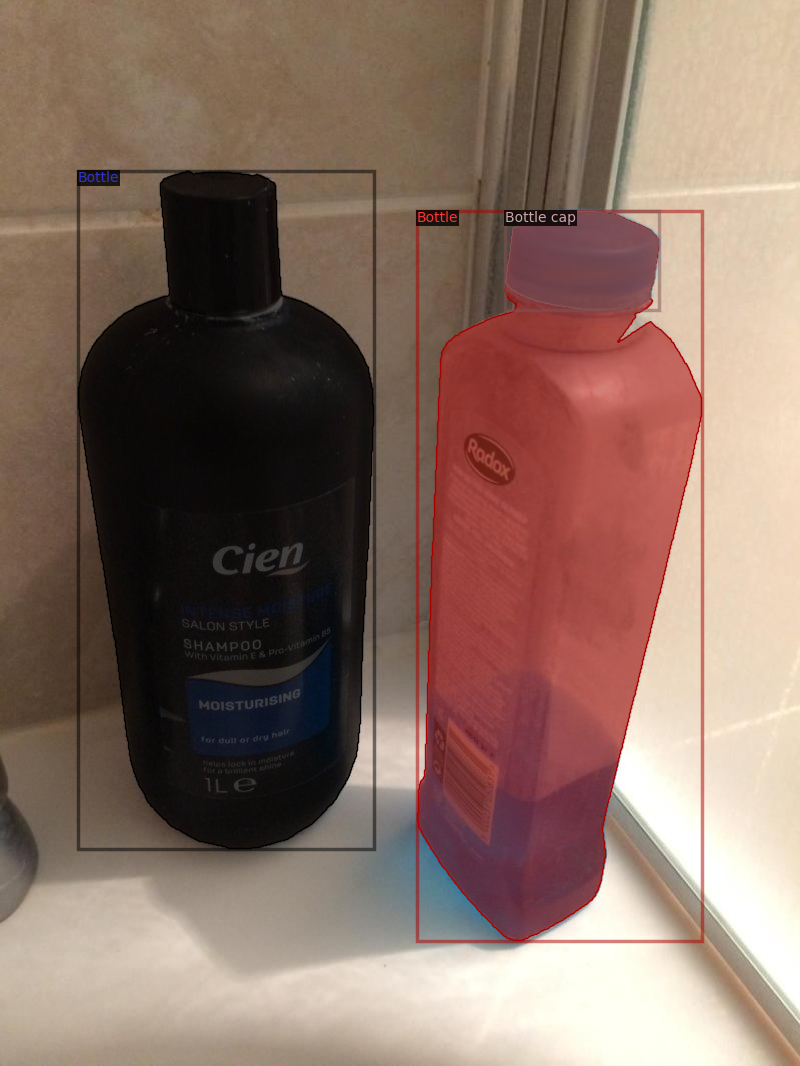

In [ ]:
d2_visualizer = Visualizer(first_entry_img, MetadataCatalog.get("TACO_val"))
d2_visualizer = d2_visualizer.draw_dataset_dict(first_entry)
cv2_imshow(d2_visualizer.get_image())

In [ ]:
os.mkdir("/content/ground truth")

for i in range(1, 16):
  os.mkdir(f"/content/ground truth/batch_{i}")

for i in tqdm(range(len(dataset_dicts_test))):
  first_entry = dataset_dicts_test[i]
  first_entry_img = cv2.imread(first_entry["file_name"])

  d2_visualizer = Visualizer(first_entry_img, MetadataCatalog.get("TACO_test"))
  out = d2_visualizer.draw_dataset_dict(first_entry)

  filename = "/".join(first_entry["file_name"].split("/")[-2:])

  cv2.imwrite("/content/ground truth/" + filename, out.get_image())

100%|██████████| 150/150 [00:25<00:00,  5.87it/s]


## MaskDINO model loading

Here we load the MaskDINO model with the configurations employed during training.

### Side note:
It is possible to set
- train_cfg_loaded.MODEL.MaskDINO.TEST.INSTANCE_ON = False
- train_cfg_loaded.MODEL.MaskDINO.TEST.SEMANTIC_ON = True

and load the weights of the MaskDINO model optimized for instance segmentation,
to obtain a model that gives as output segmentation masks, however this is just a tweak and results are not guaranteed to be coherent with what has been learned in the other task. This has been proved by analyzing the prediction of the tweaked network and observing that segmentation masks for classes that were missing in the image were non-null.

In [ ]:
train_cfg_loaded = get_cfg()
train_cfg_loaded.set_new_allowed(True)
train_cfg_loaded.merge_from_file("/content/TACO-expl/maskdino_config/taco_train_maskdino.yaml")
print(train_cfg_loaded.MODEL.BACKBONE.FREEZE_AT)
print(train_cfg_loaded.SOLVER.IMS_PER_BATCH)
print(train_cfg_loaded.INPUT.MIN_SIZE_TRAIN)
print(train_cfg_loaded.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TRAIN)
print(train_cfg_loaded.TEST.AUG.ENABLED)
print(train_cfg_loaded.INPUT.MASK_FORMAT)
print(train_cfg_loaded.Default_loading)
print(train_cfg_loaded.MODEL.MaskDINO.TEST.INSTANCE_ON)
print(train_cfg_loaded.MODEL.MaskDINO.TEST.SEMANTIC_ON)

0
2
(480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800)
100
False
polygon
False
True
False


In [ ]:
maskdino_model = build_model(train_cfg_loaded)
model_weights_path = "/content/MyDrive/MyDrive/MaskDINO_chkpts/model_final_freeze2.pth"
checkpointer = DetectionCheckpointer(maskdino_model)
checkpointer.load(model_weights_path)

Here we analyze the raw outcome of a prediction to check which tensors have gradients or gradient functions.
Unfortunately, the instance segmentation masks have none of them.

In [ ]:
maskdino_model.eval()
with torch.no_grad():
  height, width = first_entry_img.shape[:2]
  image = torch.as_tensor(first_entry_img.astype("float32").transpose(2, 0, 1))
  image.to("cuda:0")
  inputs = {"image": image, "height": height, "width": width}
  print(inputs["image"].shape)
  predictions = maskdino_model([inputs])[0]

print(predictions)

torch.Size([3, 1066, 800])
{'instances': Instances(num_instances=100, image_height=1066, image_width=800, fields=[pred_masks: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0

In [11]:
def visualize_mask(single_mask):
  """
  Utility function to plot a binary mask.
  :param single_mask: numpy array to be plot
  """
  plt.figure(figsize=(10, 10))
  plt.imshow(single_mask)
  plt.colorbar()
  plt.axis('off')
  plt.show()

Before going on with the XAI methods application, we also produce the segmentation predictions from the MaskDINO model to visually check their quality.

In [ ]:
#load the config file, load weights
train_cfg_loaded = get_cfg()
train_cfg_loaded.set_new_allowed(True)
train_cfg_loaded.merge_from_file("/content/TACO-expl/maskdino_config/taco_train_maskdino.yaml")
train_cfg_loaded.MODEL.WEIGHTS = "/content/MyDrive/MyDrive/MaskDINO_chkpts/model_final_freeze2.pth"
# Create predictor
predictor = DefaultPredictor(train_cfg_loaded)

In [ ]:
os.mkdir("/content/maskdino out")

for i in range(1, 16):
  os.mkdir(f"/content/maskdino out/batch_{i}")

for i in tqdm(range(len(dataset_dicts_test))):
  first_entry = dataset_dicts_test[i]
  first_entry_img = cv2.imread(first_entry["file_name"])

  d2_visualizer = Visualizer(first_entry_img, MetadataCatalog.get("TACO_test"))
  #predictor.eval()
  with torch.no_grad():
    predictions = predictor(first_entry_img)

  all_instance_scores = predictions["instances"].get_fields()["scores"]
  th_score_idx = np.where(all_instance_scores.cpu() > 0.30)
  filter_instances = predictions['instances'][th_score_idx]
  filter_instances = filter_instances.to('cpu')

  out = d2_visualizer.draw_instance_predictions(filter_instances)
  filename = "/".join(first_entry["file_name"].split("/")[-2:])

  cv2.imwrite("/content/maskdino out/" + filename, out.get_image())


100%|██████████| 150/150 [01:08<00:00,  2.20it/s]


## Merging of the masks

In the following cells we aim to modify the raw output of the MaskDINO model to obtain a semantic segmentation mask.

To do so, we need perform a classwise logical or of the instance segmentation
masks.

In [ ]:
print(predictions.keys())
print(predictions["instances"].get_fields().keys())
all_instance_masks = predictions["instances"].get_fields()["pred_masks"]
all_instance_scores = predictions["instances"].get_fields()["scores"]
all_instance_classes = predictions["instances"].get_fields()["pred_classes"]

th_score_idx = np.where(all_instance_scores.cpu() > 0.20)
th_masks = all_instance_masks[th_score_idx, :, :]
th_classes = all_instance_classes[th_score_idx]
n_classes = len(classes)
print(th_score_idx)
print(th_masks.shape)
print(th_classes)
print(n_classes)

dict_keys(['instances'])
dict_keys(['pred_masks', 'pred_boxes', 'scores', 'pred_classes'])
(array([ 0, 10, 21, 30]),)
torch.Size([1, 4, 1066, 800])
tensor([0, 0, 1, 0], device='cuda:0')
10


In [ ]:
def merge_masks(th_masks, th_classes, n_classes):
  """
  Function to merge MaskDINO instance masks in segmentation masks.
  :param th_masks: filtered masks
  :param th_classes: filtered instance labels
  :param n_classes: number of classes
  """
  masks = th_masks.squeeze(0)
  height, width = masks.shape[1:]
  print(height, width)
  merged = np.zeros((n_classes, height, width))
  for idx, single_mask in enumerate(masks):
    merged[th_classes[idx]] = np.logical_or(merged[th_classes[idx]], single_mask)
  merged = np.expand_dims(merged, 0)
  return merged

merged = merge_masks(th_masks.cpu(), th_classes.cpu(), n_classes)
print(merged.shape)

1066 800
(1, 10, 1066, 800)


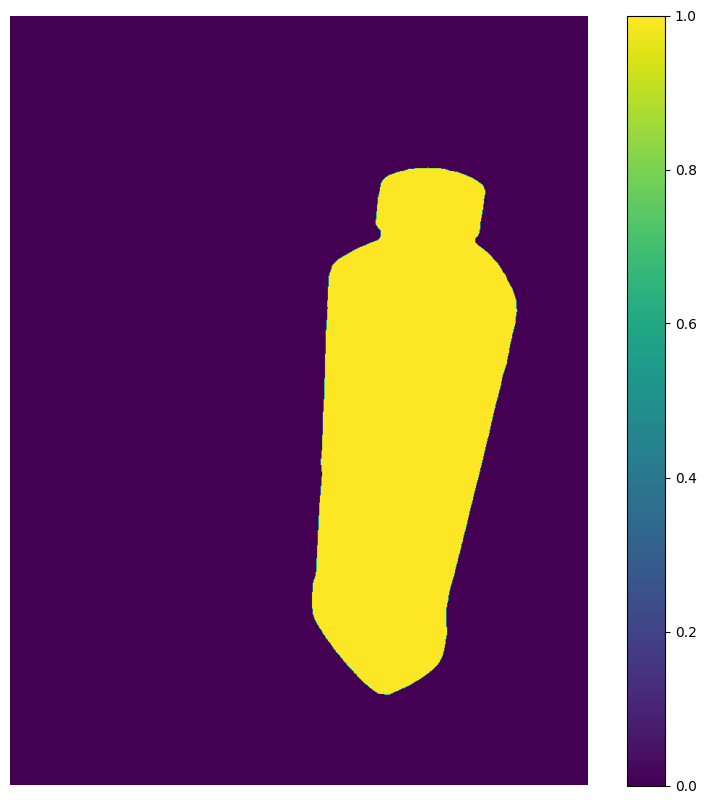

In [ ]:
# Visualization of the first instance semgentation mask
visualize_mask(th_masks[0, 0, :, :].cpu())

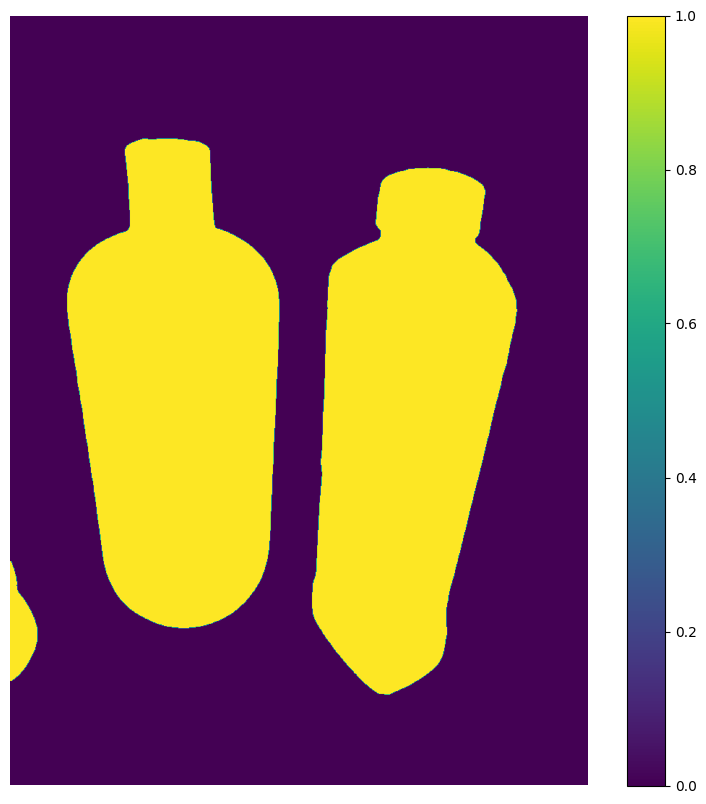

In [ ]:
# visualization of the first semantic segmentation mask
# (merged version of the above object th_masks)
visualize_mask(merged[0, 0, :, :])

## Layer selection

With the aim of applying CAM methods to our semantic segmentation masks,
we need to select certain layers of the backbone (ResNet50), which will be used to produce the maps of the most salient features for the purpose of the segmentation task.

### Side Note:

Some experiments have been carried out with specific layers, but the outcome was negative for various reasons, here we report the most salient ones:
- `backbone.res2.2` is not a valid choice as we get OOM due to the large size of the activation;
- `sem_seg_head.pixel_decoder.input_proj`, `sem_seg_head.predictor.decoder.ref_point_head` and `sem_seg_head.predictor.decoder.layers` cannot be employed due to the different datatype of the weights (`the exact error is ufunc 'isnan' not supported for the input types`)

In [ ]:
#print(maskdino_model.parameters)

target_layers_backbone_5 = [maskdino_model.get_submodule("backbone.res5.2")]
target_layers_backbone_4 = [maskdino_model.get_submodule("backbone.res4.2")]
target_layers_backbone_3 = [maskdino_model.get_submodule("backbone.res3.2")]
target_layers_backbone_5_4 = [maskdino_model.get_submodule("backbone.res4.2"), maskdino_model.get_submodule("backbone.res5.2")]
target_layers_backbone_5_4_3 = [maskdino_model.get_submodule("backbone.res3.2"),
                                maskdino_model.get_submodule("backbone.res4.2"),
                                maskdino_model.get_submodule("backbone.res5.2")]

In [ ]:
class DummyDino(nn.Module):
  """
  Wrapper for MaskDINO model
  """
  def __init__(self, dino_model, n_classes):
    """
    :param dino_model: MaskDINO model to be wrapped
    :param n_classes: number of classes in the dataset
    """
    super().__init__()
    self.dino_model = dino_model
    self.n_classes = n_classes

  def merge_masks(self, th_masks, th_classes):
    """
    Function merging instance masks into a segmentation masks.
    :param th_masks: filtered instance masks
    :param th_classes: filtered instance classes
    :returns: semantic segmentation mask of shape (self.n_classes, img_height, img_width)
    """
    masks = th_masks.squeeze(0)
    height, width = masks.shape[1:]
    merged = np.zeros((self.n_classes, height, width))
    for idx, single_mask in enumerate(masks):
      merged[th_classes[idx]] = np.logical_or(merged[th_classes[idx]], single_mask.cpu().numpy())
    merged = torch.tensor(merged).unsqueeze(0).cuda()
    return merged

  def forward(self, x):
    # adapting to model format
    height = x.shape[-2]
    width = x.shape[-1]
    to_pass = [{"image": x.squeeze(0), "height": height, "width": width}]
    # prediction
    output = self.dino_model(to_pass)[0]
    # post processing and merging
    all_instance_masks = output["instances"].get_fields()["pred_masks"]
    all_instance_scores = output["instances"].get_fields()["scores"]
    all_instance_classes = output["instances"].get_fields()["pred_classes"]
    th_score_idx = torch.where(all_instance_scores > 0.20)[0]
    th_masks = all_instance_masks[th_score_idx, :, :]
    th_classes = all_instance_classes[th_score_idx]
    seg_mask = self.merge_masks(th_masks, th_classes)
    return torch.tensor(seg_mask).cuda()

In [ ]:
maskdino_model.eval()
wrapped_dino = DummyDino(maskdino_model, 10)
input_image = totensor(first_entry_img).cuda().requires_grad_()
output = wrapped_dino(input_image)

In [ ]:
target_mask_float = np.float32(output[0, 0, :, :].detach().cpu().numpy())
print(target_mask_float.shape)

(1066, 800)


## EigenCAM plots for MaskDINO

We used the code for this [paper](https://arxiv.org/pdf/2310.01837), which extends CAM-based methods on semantic segmentation tasks. Most of them require gradients propagation which, in turn, requires gradients attached to the outputs (that are not returned by our models) and much more VRAM than the available one.

Thus, we focused on CAM methods that does not require gradients. Among them, one of the most accurate is ScoreCAM, which however generates OOM errors when applied to MaskDINO. The alternative is the EigenCAM method, but, as we will see, its maps highlight everything but the objects of interest and is insensitive of the prediction class. This inversion of trend differs from what stated in the [paper](https://arxiv.org/pdf/2008.00299).

running seg-grad-cam...
building activation list...
building gradient list...
Activations list size:  1
Gradients list size:  0
Target layer size:  1
in the loop...


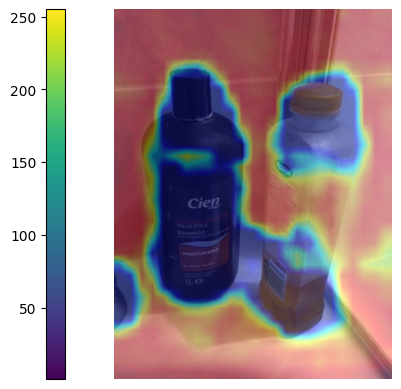

In [ ]:
# if we write any number different from 0 as first argument, the outcome is the same
targets = [SemanticSegmentationTarget(0, target_mask_float)]

print('running seg-grad-cam...')
with GRADCAM_Extensions(extension = "eigen_cam", model=wrapped_dino, target_layers = target_layers_backbone_5, use_cuda=torch.cuda.is_available(), uses_gradients = False) as eigencam:
    grayscale_cam_EX_5 = eigencam(input_tensor=input_image, targets=targets)[0, :]

grayscale_cam_EX_5.shape
[Exmap_sgc, heatmap_sgc_rgba] = show_cam_image_whu(first_entry_img, grayscale_cam_EX_5, 0.006)
plt.imshow(Exmap_sgc)
plt.axis('off')
plt.colorbar(location='left')

running seg-grad-cam...
building activation list...
building gradient list...
Activations list size:  1
Gradients list size:  0
Target layer size:  1
in the loop...


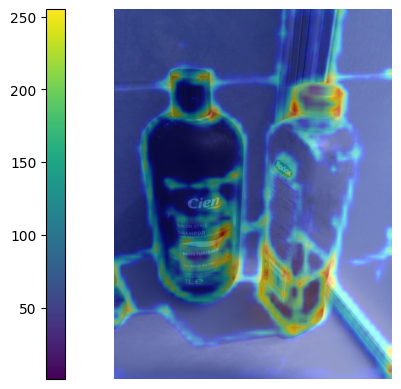

In [ ]:
targets = [SemanticSegmentationTarget(0, target_mask_float)]

print('running seg-grad-cam...')
with GRADCAM_Extensions(extension = "eigen_cam", model=wrapped_dino, target_layers = target_layers_backbone_4, use_cuda=torch.cuda.is_available(), uses_gradients = False) as eigencam:
    grayscale_cam_EX_4 = eigencam(input_tensor=input_image, targets=targets)[0, :]

grayscale_cam_EX_4.shape
[Exmap_sgc, heatmap_sgc_rgba] = show_cam_image_whu(first_entry_img, grayscale_cam_EX_4, 0.006)
plt.imshow(Exmap_sgc)
plt.axis('off')
plt.colorbar(location='left')

running seg-grad-cam...
building activation list...
building gradient list...
Activations list size:  1
Gradients list size:  0
Target layer size:  1
in the loop...


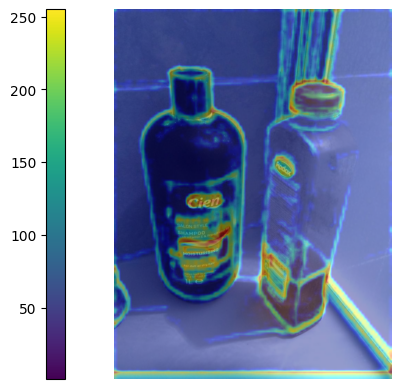

In [ ]:
targets = [SemanticSegmentationTarget(0, target_mask_float)]

print('running seg-grad-cam...')
with GRADCAM_Extensions(extension = "eigen_cam", model=wrapped_dino, target_layers = target_layers_backbone_3, use_cuda=torch.cuda.is_available(), uses_gradients = False) as eigencam:
    grayscale_cam_EX_3 = eigencam(input_tensor=input_image, targets=targets)[0, :]

grayscale_cam_EX_3.shape
[Exmap_sgc, heatmap_sgc_rgba] = show_cam_image_whu(first_entry_img, grayscale_cam_EX_3, 0.006)
plt.imshow(Exmap_sgc)
plt.axis('off')
plt.colorbar(location='left')

running seg-grad-cam...
building activation list...
building gradient list...
Activations list size:  2
Gradients list size:  0
Target layer size:  2
in the loop...
in the loop...


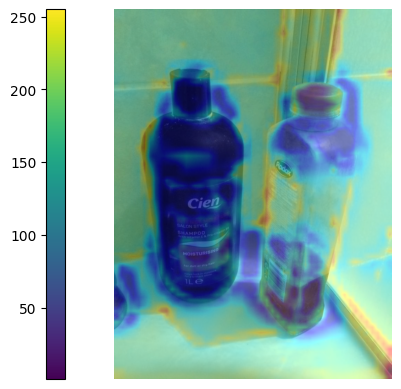

In [ ]:
targets = [SemanticSegmentationTarget(0, target_mask_float)]

print('running seg-grad-cam...')
with GRADCAM_Extensions(extension = "eigen_cam", model=wrapped_dino, target_layers = target_layers_backbone_5_4, use_cuda=torch.cuda.is_available(), uses_gradients = False) as eigencam:
    grayscale_cam_EX_5_4 = eigencam(input_tensor=input_image, targets=targets)[0, :]

grayscale_cam_EX_5_4.shape
[Exmap_sgc, heatmap_sgc_rgba] = show_cam_image_whu(first_entry_img, grayscale_cam_EX_5_4, 0.006)
plt.imshow(Exmap_sgc)
plt.axis('off')
plt.colorbar(location='left')

running seg-grad-cam...
building activation list...
building gradient list...
Activations list size:  3
Gradients list size:  0
Target layer size:  3
in the loop...
in the loop...
in the loop...


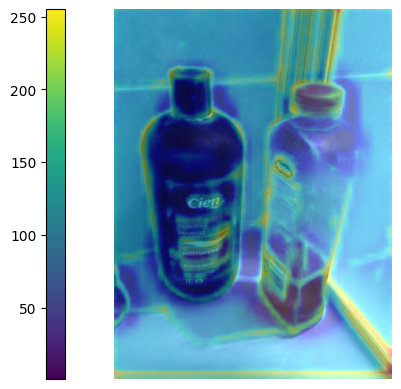

In [ ]:
targets = [SemanticSegmentationTarget(0, target_mask_float)]

print('running seg-grad-cam...')
with GRADCAM_Extensions(extension = "eigen_cam", model=wrapped_dino, target_layers = target_layers_backbone_5_4_3, use_cuda=torch.cuda.is_available(), uses_gradients = False) as eigencam:
    grayscale_cam_EX_5_4_3 = eigencam(input_tensor=input_image, targets=targets)[0, :]

grayscale_cam_EX_5_4_3.shape
[Exmap_sgc, heatmap_sgc_rgba] = show_cam_image_whu(first_entry_img, grayscale_cam_EX_5_4_3, 0.006)
plt.imshow(Exmap_sgc)
plt.axis('off')
plt.colorbar(location='left')

As we can notice, these maps are not so informative of the predictions, and, as briefly mentioned, highlight everything bu the objects of interest (first plot).

The other plots highlight the contours of the objects of interest. This happens because they are releated to less deep ResNet stages, which are meant to extract low-level featrues as edges or vertical/horizontal contours.

## ScoreCAM plots for Mask-Frozen DETR
Differently from MaskDINO, the Mask-Frozen DETR model requires less resources and the ScoreCAM method can be applied without OOM errors. The only requirements resides in selecting the L4 GPU on the Colab Environment.

In [5]:
# loading the MFDETR model
mfdetr_path = '/content/MyDrive/MyDrive/checkpointML4CV/MFDETRllmsn2layer4finalcheckpoint_6.pth'
device = "cuda"
num_classes = 10

args = get_DETRargs()
args.aux_loss = False
mfdetr, postprocessor = load_mfdetr(mfdetr_path, args, num_classes, device)
mfdetr = mfdetr.to(device)

topk for eval: 100


In [7]:
# Helper functions to filter results depending on IoU and confidence score

class_names = ["Bottle", "Bottle cap", "Can", "Cigarette", "Cup", "Lid", "Other", "Plastic bag & wrapper", "Pop tab", "Straw"]

def filter_results(results, th_iou=0.001, th_score=0.1):
  """
  Function filtering the MFDETR results given two criteria: low intersection
  over union score (if a box has the same class w.r.t. some other overlapping one)
  or low confidence score.
  :params results: output of the MFDETR model, postprocessed
  :params th_iou: threshold for the intersection over union scores, to be applied
                  to overlapping boxes with the same class
  :params th_score: threshold for the confidence score (a box is kept if its score is higher)
  :returns: the filtered output
  """
  res = {"boxes": results[0]["boxes"][0].unsqueeze(0),
         "labels": results[0]["labels"][0].unsqueeze(0),
         "masks": results[0]["masks"][0],
         "scores": results[0]["scores"][0].unsqueeze(0)}

  for (box, label, mask, score) in zip(results[0]["boxes"][1:], results[0]["labels"][1:], results[0]["masks"][1:], results[0]["scores"][1:]):
    scores = generalized_box_iou(box.unsqueeze(0), res["boxes"][res["labels"] == label])

    if not ((scores > th_iou).any()) and not any([(box == _box).all() for _box in res["boxes"]]) and score > th_score:
      res["boxes"] = torch.vstack((res["boxes"], box))
      res["labels"] = torch.hstack((res["labels"], label))
      res["masks"] = torch.vstack((res["masks"], mask))
      res["scores"] = torch.hstack((res["scores"], score))

  return res

def sort_results_by_score(results):
  """
  Function sorting the results of the MFDETR model on the score in descending order
  :param results: output of the MFDETR model, postprocessed
  :returns: results sorted by score
  """
  _, sorted_indices = torch.sort(results[0]["scores"], descending=True)

  for k, v in results[0].items():
    results[0][k] = torch.stack([v[i] for i in sorted_indices], dim=0)

  return results

As done for the MaskDINO, we create a wrapper model for the Mask-Frozen DETR. This model has some extra functions in the forward method that format a input image (torch tensor) in the way the model accepts it and performs post-processing and filtering, as well as semantic mask merging, on the output.

In [8]:
class DummyMFD(nn.Module):
  """
  Wrapper for the Mask-Frozen DETR
  """
  def __init__(self, MFD_model, postproc, n_classes):
    """
    :params MFD_model: Mask-Frozen DETR model instance
    :params postproc: postprocessors to be applied on the output
    :params n_classes: number of classes of the dataset
    """
    super().__init__()
    self.MFD_model = MFD_model
    self.n_classes = n_classes
    self.post = postproc


  def merge_masks(self, th_masks, th_classes):
    """
    Merges instance masks into a semantic segmentation mask
    :param th_masks: filtered instance masks
    :param th_classes: filtered insteance labels
    :returns: a semantic segmentation mask of shape (n_classes, img_height, img_width)
    """
    masks = th_masks
    height, width = masks.shape[1:]
    merged = torch.zeros((self.n_classes, height, width))
    for idx, single_mask in enumerate(masks):
      idxi = th_classes[idx].item()
      merged[idxi] = torch.max(merged[idxi], single_mask)
    merged = np.expand_dims(merged, 0)
    return merged

  def forward(self, x):
    # adapting the format
    batch_input = mutils.collate_fn([x])
    batch_input = batch_input[0].to("cuda")
    # getting the output
    output = self.MFD_model(batch_input)
    # post-processing and filtering
    orig_target_sizes = torch.tensor([[x.shape[-2], x.shape[-1]]]).to("cuda")
    results = self.post["bbox"](output, orig_target_sizes)
    results = self.post["segm"](results, output, orig_target_sizes, orig_target_sizes)
    sorted_res = sort_results_by_score(results)
    filtered_res = filter_results(sorted_res, 0.001, 0.2)
    # mask merging
    seg_mask = self.merge_masks(filtered_res["masks"], filtered_res['labels']-1)
    return torch.tensor(seg_mask).cuda()

In [9]:
def swin_reshape(x, height=34, width=25):
  """
  function required to reshape swin activations
  :params x: activation map
  :params height: height of the activation map after reshaping.
                  should be image height//32
  :params width: width of the activation map after reshaping.
                  should be image width//32
  :returns: reshaped activation map
  """
  result = x.reshape(x.size(0), height, width, x.size(2))

  result = result.transpose(2, 3).transpose(1, 2)
  return result

To generate the map we choose a test image, the "bottle cap" category and we obtain the activation from the last layer of the swin backbone.

In [13]:
target_layers_backbone = [mfdetr.detr.backbone[0].body.layers[-1].blocks[-1].norm2]
norm = T.Compose( [T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
cat = 1
# wrapper method
mfdetr.eval()
wrapped_mfd = DummyMFD(mfdetr,postprocessor, 10)

# gets the image and normalizes it
first_entry = dataset_dicts_test[0]
first_entry_img = Image.open(first_entry["file_name"])

input_image = first_entry_img
n_image, _ = norm(input_image, None)
output = wrapped_mfd(n_image.unsqueeze(0))
target_mask_float = np.float32(output[0, cat, :, :].detach().cpu().numpy())



First we visualize the image with the prediction

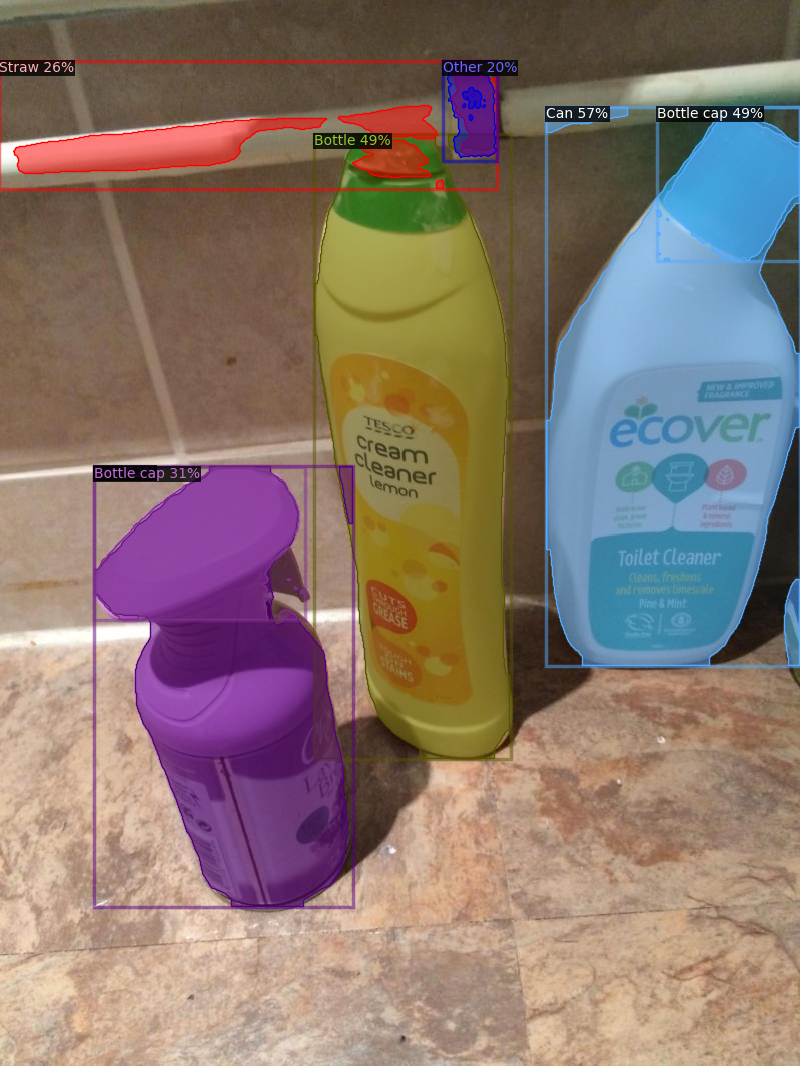

In [25]:
d2_visualizer = Visualizer(first_entry_img, MetadataCatalog.get("TACO_test"))

# pre process image
tr_image, _ = norm(first_entry_img, target=None)
tr_image = tr_image.unsqueeze(0)
batch_input = mutils.collate_fn([tr_image])
batch_input = batch_input[0].to("cuda")
# produce outputs
output = mfdetr(batch_input)

# post process outputs
orig_target_sizes = torch.tensor([[first_entry_img.size[1], first_entry_img.size[0]]]).to("cuda")
results = postprocessor["bbox"](output, orig_target_sizes)
results = postprocessor["segm"](results, output, orig_target_sizes, orig_target_sizes)
sorted_res = sort_results_by_score(results)
filtered_res = filter_results(sorted_res, 0.001, 0.2)
filtered_res["pred_masks"] = filtered_res.pop("masks").to("cpu")
filtered_res["pred_classes"] = filtered_res.pop("labels").to("cpu") - 1
filtered_res["pred_boxes"] = filtered_res.pop("boxes").to("cpu")
filtered_res["scores"] = filtered_res["scores"].to("cpu")
# use detectron2 utilities to print predictions
insta = Instances(image_size=(first_entry_img.size[1], first_entry_img.size[0]), **filtered_res)
img_with_mask = d2_visualizer.draw_instance_predictions(insta).get_image()
Image.fromarray(img_with_mask)

Here we visualize the map we are trying to explain.

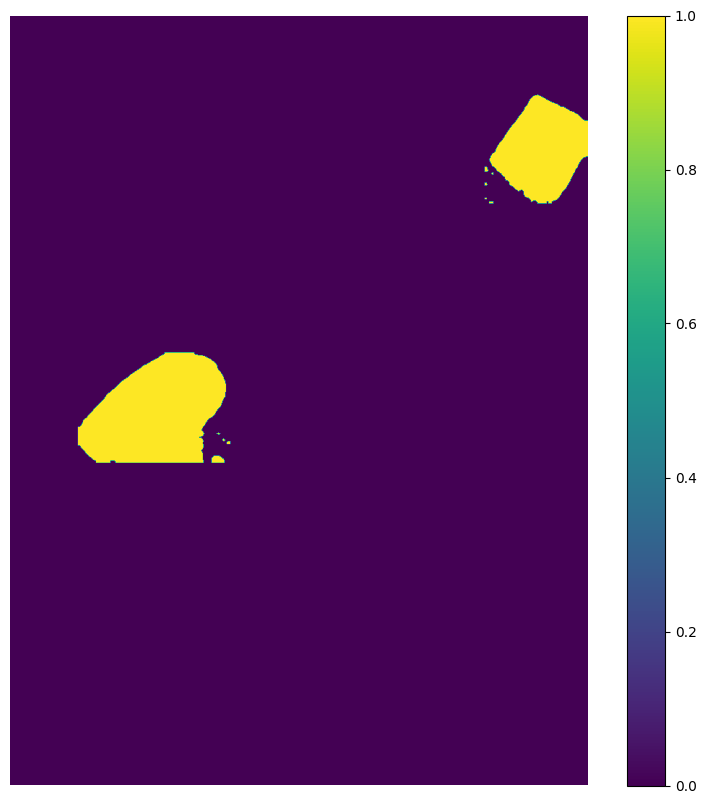

In [14]:
visualize_mask(target_mask_float)

torch.Size([3, 1066, 800])
(1066, 800)
running seg-grad-cam...
building activation list...
building gradient list...
Activations list size:  1
Gradients list size:  0
Target layer size:  1
in the loop...


100%|██████████| 768/768 [11:02<00:00,  1.16it/s]


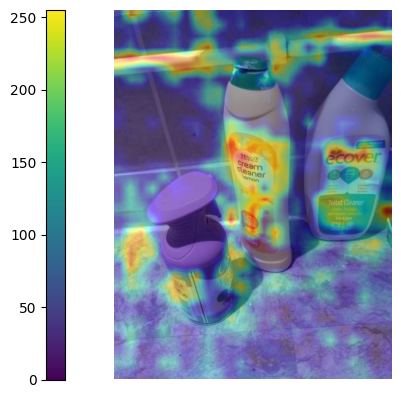

In [ ]:
print(target_mask_float.shape)

targets = [SemanticSegmentationTarget(cat, target_mask_float)]
print('running seg-grad-cam...')
with GRADCAM_Extensions(extension = "score_cam", model=wrapped_mfd, target_layers = target_layers_backbone, use_cuda=torch.cuda.is_available(), uses_gradients = False, reshape_transform=swin_reshape) as scorecam:
    grayscale_cam_EX_5 = scorecam(input_tensor=n_image.unsqueeze(0), targets=targets)[0, :]

grayscale_cam_EX_5.shape
[Exmap_sgc, heatmap_sgc_rgba] = show_cam_image_whu(np.array(first_entry_img),
                                                   grayscale_cam_EX_5, 0.006)
plt.imshow(Exmap_sgc)
plt.axis('off')
plt.colorbar(location='left')

As we can see, the ScoreCAM is more informative when compared with the eigenCAM, as for the selected map, it actually highlights useful sections. In fact, considering the segmentation map and the target class, the parts that are highlighted are mainly the bodies of the bottles on which the caps are usually found. This map is not so precise, however, as it highlights also the bar on the background which may not completely be linked to our prediction.

We can notice that also this extension of the CAM method suffers from the same problem of its vanilla version when applied on transformer backbones, that is, it prdouces grid-like artifacts on the bounds of the patches that the transformer uses as tokens.

In conclusion, this method may be helpful when applied on Mask-Frozen DETR, but it still requires more resoruces than the one applied directly on the bounding box predictions. Moreover, the latter addresses the most important part of the prediction pipeline of this model, that is the detection module, which addresses both the class prediction as well as the area where the mask must be produced.

### Mask-Frozen DETR segmentation results
As done for the MaskDINO model, we alo plot the instance segmentation results of Mask-Frozen DETR for visual inspection.

In [ ]:
os.mkdir("/content/mfdetr out")

for i in range(1, 16):
  os.mkdir(f"/content/mfdetr out/batch_{i}")

# set required pre-processing operations
normalize = T.Compose( [T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
mfdetr.eval()

for i in tqdm(range(len(dataset_dicts_test))):
  img_meta = dataset_dicts_test[i]
  img = Image.open(img_meta["file_name"])
  d2_visualizer = Visualizer(img, MetadataCatalog.get("TACO_test"))

  # pre process image
  tr_image, _ = normalize(img, target=None)
  tr_image = tr_image.unsqueeze(0)
  batch_input = mutils.collate_fn([tr_image])
  batch_input = batch_input[0].to("cuda")
  # produce outputs
  output = mfdetr(batch_input)

  # post process outputs
  orig_target_sizes = torch.tensor([[img.size[1], img.size[0]]]).to("cuda")
  results = postprocessor["bbox"](output, orig_target_sizes)
  results = postprocessor["segm"](results, output, orig_target_sizes, orig_target_sizes)
  sorted_res = sort_results_by_score(results)
  filtered_res = filter_results(sorted_res, 0.001, 0.2)
  filtered_res["pred_masks"] = filtered_res.pop("masks").to("cpu")
  filtered_res["pred_classes"] = filtered_res.pop("labels").to("cpu") - 1
  filtered_res["pred_boxes"] = filtered_res.pop("boxes").to("cpu")
  filtered_res["scores"] = filtered_res["scores"].to("cpu")

  # use detectron2 utilities to print predictions
  insta = Instances(image_size=(img.size[1], img.size[0]), **filtered_res)
  img_with_mask = d2_visualizer.draw_instance_predictions(insta).get_image()
  pilimg = Image.fromarray(img_with_mask)
  filename = "/".join(img_meta["file_name"].split("/")[-2:])
  pilimg.save("/content/mfdetr out/" + filename)
